# Evaluator - optimizer

In the evaluator-optimizer workflow, one LLM call generates a response while another provides evaluation and feedback in a loop:

When to use this workflow: This workflow is particularly effective when we have clear evaluation criteria, and when iterative refinement provides measurable value. The two signs of good fit are, first, that LLM responses can be demonstrably improved when a human articulates their feedback; and second, that the LLM can provide such feedback. This is analogous to the iterative writing process a human writer might go through when producing a polished document.

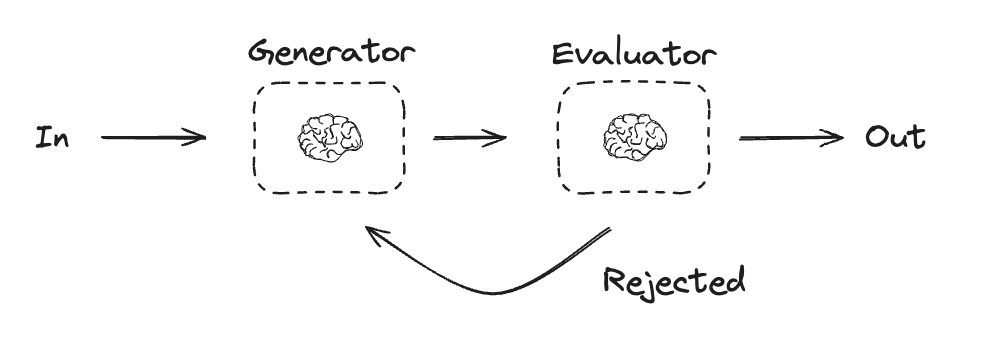

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from typing_extensions import Literal
from langchain_core.messages import HumanMessage, SystemMessage
from pydantic import BaseModel, Field

In [2]:
from langchain_openai import ChatOpenAI
import os

# build your agent
llm = ChatOpenAI(
    model="gpt-4o-mini",            # Use a lightweight GPT-4 model
    temperature=0,                  # Deterministic output (no randomness)
    api_key=os.environ["OPEN_AI_SECRET_KEY"]  # Pull your OpenAI key from environment
)

In [3]:
# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

In [4]:
# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


In [9]:
# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)

In [7]:
# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


In [10]:

def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


In [11]:
# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"

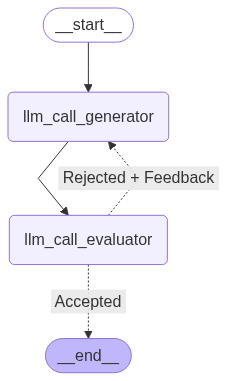

Why was the cat sitting on the computer?

Because it wanted to keep an eye on the mouse!


In [12]:
# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])